In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from joblib import dump, load


# Load the dataset
df = pd.read_csv('data/df.csv')
df.head()

,child_had_diarrhoea_last_two_weeks,child_ill_fever_two_weeks,child_ill_cough_two_weeks,child_weight_kg,child_lenhei_cm,area,region,sex,age_days,mother_educational_level,health_insurance,mother_functional_disability_18_49,ethnicity,combined_wealth_score,wealth_index_quintile,wealth_index_decile,stunting
0,No,No,No,9.5,77.8,Rural,Western,Male,622,Jss/jhs/middle,With insurance,Has no functional difficulty,Akan,0.153212,Middle,6th decile,Stunting
1,Yes,No,Yes,7.0,70.6,Rural,Western,Female,431,Primary,Without insurance,Has functional difficulty,Akan,-0.068991,Middle,5th decile,Stunting
2,No,Yes,No,11.9,95.3,Rural,Western,Female,1295,Jss/jhs/middle,Without insurance,Has no functional difficulty,Akan,-0.263641,Middle,5th decile,Normal
3,No,Yes,No,9.8,78.6,Rural,Western,Female,532,Jss/jhs/middle,Without insurance,Has no functional difficulty,Akan,-0.263641,Middle,5th decile,Normal
4,No,No,Yes,14.9,100.1,Rural,Western,Male,1607,Primary,With insurance,Has no functional difficulty,Akan,0.087765,Middle,6th decile,Normal


In [3]:
# Encode categorical variables
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
    
# Splitting the data into training and test sets
X = df.drop('stunting', axis=1)
y = df['stunting']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display the shape of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6071, 16), (2603, 16), (6071,), (2603,))

In [4]:
# Baseline accuracy
acc_baseline = df["stunting"].value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.825


In [5]:
# Using a base Random Forest model to identify important features
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
feature_importances = rf.feature_importances_
features = X.columns
important_features = pd.Series(feature_importances, index=features)
important_features

child_had_diarrhoea_last_two_weeks    0.010197
child_ill_fever_two_weeks             0.012971
child_ill_cough_two_weeks             0.011714
child_weight_kg                       0.127403
child_lenhei_cm                       0.250733
area                                  0.009519
region                                0.039837
sex                                   0.016044
age_days                              0.312842
mother_educational_level              0.024727
health_insurance                      0.013912
mother_functional_disability_18_49    0.012808
ethnicity                             0.031114
combined_wealth_score                 0.087258
wealth_index_quintile                 0.013056
wealth_index_decile                   0.025864
dtype: float64

In [6]:
# Top five features
important_features = pd.Series(feature_importances, index=features).nlargest(3)
important_features

age_days           0.312842
child_lenhei_cm    0.250733
child_weight_kg    0.127403
dtype: float64

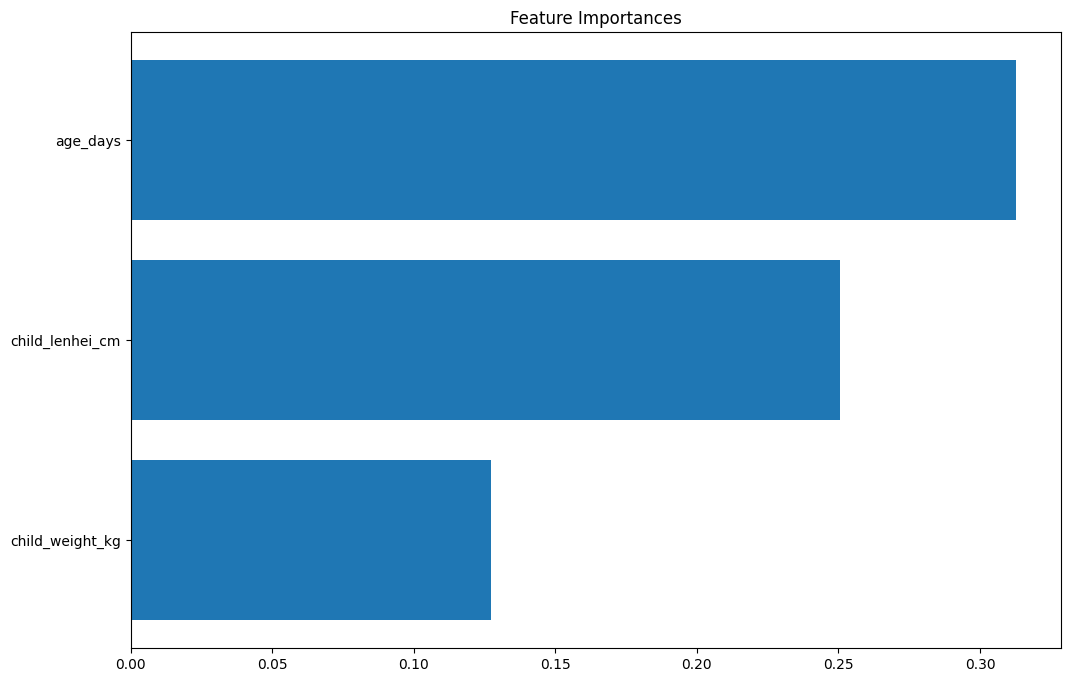

In [7]:
# Plot feature importances
plt.figure(figsize=(12, 8))
indices = np.argsort(important_features)[::-1]
plt.title('Feature Importances')
plt.barh(range(len(important_features)), important_features[indices], align='center')
plt.yticks(range(len(important_features)), [important_features.index[i] for i in indices])
plt.gca().invert_yaxis()
plt.show()

In [8]:
# Selecting the top 5 important features for training
selected_features = important_features.index.tolist()
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Ridge Regression': RidgeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Training and evaluating models
results = {}
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

results

{'Logistic Regression': 0.8574721475220899,
 'Ridge Regression': 0.8578563196311948,
 'SVM': 0.8267383787936996,
 'XGBoost': 0.9585094122166731,
 'Naive Bayes': 0.8267383787936996,
 'Neural Network': 0.7894736842105263,
 'KNN': 0.936611601997695,
 'Random Forest': 0.9596619285439877}

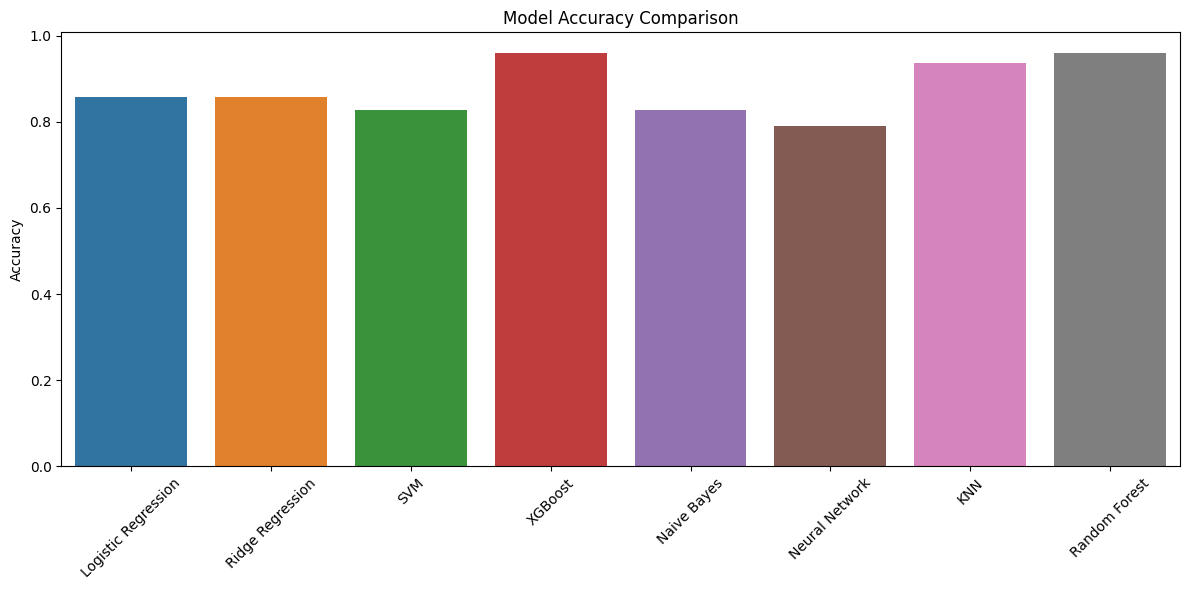

In [9]:
# Visualizing the accuracy of each model
plt.figure(figsize=(12, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()), color='blue')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

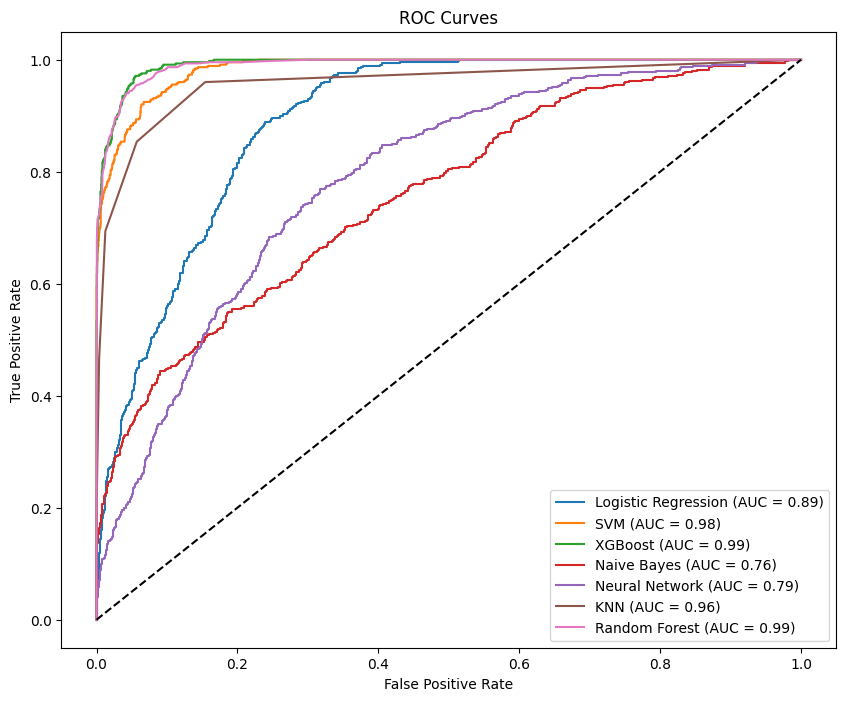

In [10]:
# Plotting ROC curves for all models except RidgeClassifier
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if name != 'Ridge Regression':  # Exclude RidgeClassifier
        y_prob = model.predict_proba(X_test_selected)[:, 1]  # Probability of the positive class
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

In [ ]:
def predict_test(model):
    """
    Create prediction from test data
    
    Args:
    -----
    model: specify pre-trained model
    
    Returns:
    y_pred (Series): prediction of test data
    """

    y_pred = model.predict(X_test_selected)

    return y_pred

In [ ]:
with open("xgb.joblib", "rb") as file:
    xgboost = load(file)
    
with open("model.joblib", "rb") as file:
    rf = load(file)

In [ ]:
y_xgboost = predict_test(xgboost)
y_rf = predict_test(rf)

In [ ]:
accuracy = accuracy_score(y, y_xgboost)
print(accuracy)

In [ ]:
cm_lr = confusion_matrix(y, y_xgboost)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp.plot()

In [ ]:
print(classification_report(y, y_xgboost))

## Communicate results

In [11]:
def make_predictions(age, lenhei, weight):
    # Data to pass to the model
    data = {
        "age_days": age,
        "child_lenhei_cm": lenhei,
        "child_weight_kg": weight,
    }
    
    # Pass the data into a pandas dataframe
    df = pd.DataFrame(data, index=[0])
    
    # Generate prediction
    prediction = models["Random Forest"].predict(df)[0]
    
    if prediction == 0:
        print("The child's nutritonal status is normal")
    else:
        print("The child is stunted")

In [12]:
make_predictions(274, 73, 9.3)

The child's nutritonal status is normal


In [13]:
# Save random forest model
dump(models["XGBoost"], 'xbg.joblib')

['xbg.joblib']